## Housekeeping

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib as mpl
from matplotlib import pyplot as plt
import numpy as np
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score
from scipy.optimize import curve_fit

In [2]:
cd O:\TUD\__Arp-cortex\_____final-for-thesis\code\data

O:\TUD\__Arp-cortex\_____final-for-thesis\code\data


In [3]:
sns.set_context('talk')

In [4]:
df = pd.read_csv('20220315_bouquet-counting.txt', sep='\t', decimal=",")

In [5]:
df.loc[((df['tubes']==1) & (df['spikes']==1), 'type')] = 'both'
df.loc[((df['tubes']==1) & (df['spikes']==0), 'type')] = 'tube'
df.loc[((df['tubes']==0) & (df['spikes']==1), 'type')] = 'spike'

df.head(3)

,image,bouquet,number of protrusions,widest angle,actin enriched in profile,actin enriched visibly,tubes,spikes,comments,type
0,20211114_run4_8uMactin_VCA0-5uM_00116-4,1,6,110.07,1.0,1.0,1,0,NaN,tube
1,20211114_run4_8uMactin_VCA0-5uM_0018-4,1,7,126.43,1.0,1.0,1,0,NaN,tube
2,20211114_run4_8uMactin_VCA0-5uM_0011-9,1,2,118.18,0.0,0.5,1,0,channels are shifted,tube


### What fraction of bouquets has actin enriched?

In [6]:
# how many bouquets?
len(df)

70

In [7]:
100*len(df.loc[df['actin enriched in profile']==1])/len(df)

78.57142857142857

### What if we only consider the GUVs where the profile can be clearly extracted?

In [8]:
len(df.loc[df['comments'].isna()])

58

In [9]:
100*len(df.loc[(df['actin enriched in profile']==1) & (df['comments'].isna())])/len(df.loc[df['comments'].isna()])

87.93103448275862

In [10]:
100*len(df.loc[(df['actin enriched visibly']==1) & (df['comments'].isna())])/len(df.loc[df['comments'].isna()])

93.10344827586206

## Plotting

In [11]:
len(df.loc[df['type']=='both'])

25

In [12]:
len(df.loc[df['type']=='tube'])

31

In [13]:
len(df.loc[df['type']=='spike'])

14

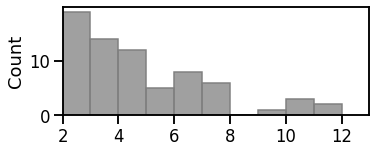

In [14]:
f = plt.figure(figsize=[5.5, 2])

ax = sns.histplot(data=df, x='number of protrusions', color='grey', edgecolor='grey', bins=df['number of protrusions'].max()-2)
ax.set_xlim(2,13)
ax.set_xlabel('')

fig = ax.get_figure()
fig.savefig('protrusions-per-bouquet.png', dpi=300, bbox_inches='tight')

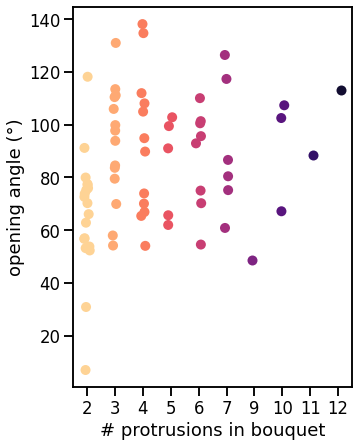

In [15]:
f = plt.figure(figsize=[5, 7])
ax = sns.stripplot(data=df, y='widest angle', x='number of protrusions', palette='magma_r', size=10)
#sns.violinplot(data=df, y='widest angle', color='w')

ax.set_xlabel('# protrusions in bouquet')
ax.set_ylabel('opening angle (°)')

fig = ax.get_figure()
fig.savefig('angles-vs-numbers.png', dpi=300, bbox_inches='tight')

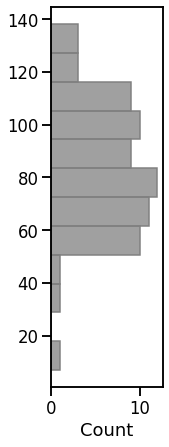

In [16]:
f = plt.figure(figsize=[2, 7])
ax=sns.histplot(data=df, y='widest angle', color='grey', edgecolor='grey', bins=12)

ax.set_xlabel('Count')
ax.set_ylabel('')

fig = ax.get_figure()
fig.savefig('angles_aggregated-hist.png', dpi=300, bbox_inches='tight')

<AxesSubplot:xlabel='type', ylabel='widest angle'>

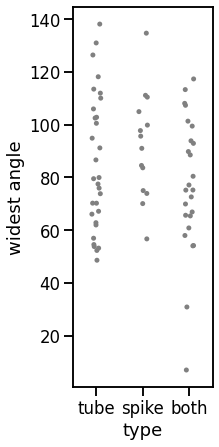

In [17]:
f = plt.figure(figsize=[2.5, 7])
sns.stripplot(data=df, x='type', y='widest angle', color='grey')
#sns.violinplot(data=df, x='type', y='widest angle', color='w')

In [18]:
df_mini = pd.DataFrame(columns=['type', 'number', 'fraction'])
df_mini['type']=['tube', 'spike', 'both']
#df_mini['number']=len(df.loc[df['type']==df_mini['type']])#[len('tube'), 'spike', 'both']
df_mini['number'] = [len(df.loc[df['type']=='tube']), 
                     len(df.loc[df['type']=='spike']), 
                     len(df.loc[df['type']=='both']) ] 
df_mini['fraction']=100*df_mini['number']/df_mini.sum()['number']

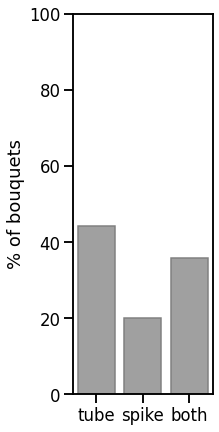

In [19]:
f = plt.figure(figsize=[2.5, 7])
ax = sns.barplot(data = df_mini, 
                 x='type', y='fraction',
                color='#a0a0a0', edgecolor='grey')

ax.set_ylim(0,100)
ax.set_xlabel('')
ax.set_ylabel('% of bouquets')

fig = ax.get_figure()
fig.savefig('bouquet-types.png', dpi=300, bbox_inches='tight')

Example bouquet plotting

<AxesSubplot:xlabel='distance (um)', ylabel='grey value'>

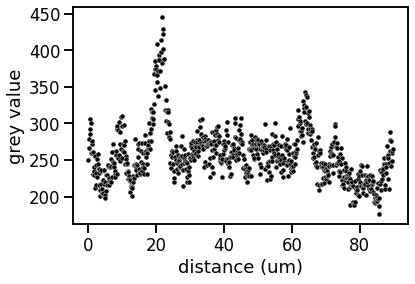

In [21]:
profile = '20211114_run2_8uMactin_VCA2uM_00117-1_actin_bouq2.csv'

df_profile = pd.read_csv(profile, 
                         skiprows=[0], names=['distance (um)', 'grey value'])
#df_membrane = pd.read_csv('20211114_run2_8uMactin_VCA2uM_0011_zstack-2_membrane.csv', 
#                          skiprows=[0], names=['distance (um)', 'grey value'])

sns.scatterplot(data=df_profile, x='distance (um)', y='grey value', color='k', s=25)

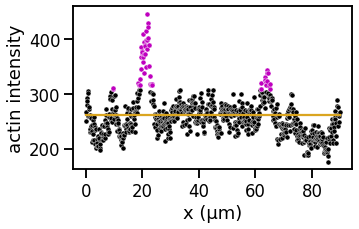

In [22]:
min_x = 25
max_x = 55
elevation = 2.5

cutoff_signal = df_profile.loc[
    (df_profile['distance (um)']<max_x) & (df_profile['distance (um)']>min_x)]['grey value'].mean() + elevation*df_profile.loc[
    (df_profile['distance (um)']<max_x) & (df_profile['distance (um)']>min_x)]['grey value'].std()


f = plt.figure(figsize=[5, 3])
ax = sns.scatterplot(
    data=df_profile.loc[df_profile['grey value']< cutoff_signal], 
    x='distance (um)', y='grey value', 
    color='k', s=25)

sns.scatterplot(
    data=df_profile.loc[df_profile['grey value']> cutoff_signal], 
    x='distance (um)', y='grey value', 
    color='m', s=25)


X = df_profile['distance (um)'].values
Y=len(X)*[df_profile.loc[(df_profile['distance (um)']<max_x) & (df_profile['distance (um)']>min_x)]['grey value'].mean()]
plt.plot(X, Y, 'goldenrod')

#ax.set_title(profile+' '+str(elevation)+'', fontsize=12)
ax.set_xlabel('x (\u03bcm)')
ax.set_ylabel('actin intensity')

fig = ax.get_figure()
fig.savefig('profile_'+profile+'_'+str(elevation)+'SD'+'.png', dpi=300, bbox_inches='tight')